In [133]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as la

In [134]:
def rand_v_p(p=3):
    return np.random.normal(0, np.sqrt(p))

def rand_accel_bias(sigma_squared=1e-6):
    return np.random.normal(0, np.sqrt(sigma_squared))

def rand_accel_noise(sigma_squared=2.5e-3):
    return np.random.normal(0, np.sqrt(sigma_squared))

def accel(t):
    return np.sin(t)
    # return 1

## Part 1
Kalman filter is as follows:

$\Phi$ is defined as:

$$
x_k^{-} =
\left[\begin{array}{cc} 
x_k \\
v_k \\
b_k
\end{array}\right]
 =
\left[\begin{array}{cc} 
0 & 1 & 0\\
0 & 0 & 1\\
0 & 0 & 0
\end{array}\right]
\left[\begin{array}{cc} 
x_{k-1}\\
v_{k-1}\\
b_{k-1}
\end{array}\right]
+
\left[\begin{array}{cc} 
0 & 0\\
1 & 0\\
0 & 1\\
\end{array}\right]
\left[\begin{array}{cc} 
a\\
w_b
\end{array}\right]
$$ 

$$
y_k =
\left[\begin{array}{cc} 
1 & 0 & 0\\
\end{array}\right]
\left[\begin{array}{cc} 
p\\
v\\
b
\end{array}\right]
$$

Note: a $-$ in the exponent denotes non-corrected guesses, and a $+$ in the exponent denotes a corrected guess given measurements.

Prediction step-

$x_k^{-} = \Phi_k x_{k-1}$

$P_k^{-} = \Phi_k P_{k-1} Phi_k^T + Q_k$

Correction step-

$e_k = y_k - H_kx_k^{-}$

$S_k = H_kP_k^{-}H_k^T + R_k$

$L_k = P_k^{-}H_k^TS_k^{-1}$

$x_k^{+} = x_k^{-} + L_ke_k$

$P_k^{+} = P_k^{-} - L_kS_kL_k^T$

In [135]:
T = 500
dt = 0.01

A = np.array([
    [0, 1, 0],
    [0, 0, 1],
    [0, 0, 0]
])

B = np.array([
    [0, 0],
    [1, 0],
    [0, 1]
])

zeta = 2.5e-3

P = np.eye(3)
Q = np.eye(3) * zeta
H = np.array([[1,0,0]])
R = np.array([3]) # GPS Noise, variance of the sensor 53/107

In [136]:
x = [0]
actual_x = [0]
v = [0]
actual_v = [0]
y = [0]
actual_y = [0]
bias = [0]
a = [0]
actual_a = [0]
P_1 = [1]
P_2 = [1]

In [137]:
x_t = x[0]
actual_x_t = actual_x[0]
v_t = v[0]
actual_v_t = actual_v[0]
y_t = y[0]
actual_y_t = actual_y[0]
bias_t = bias[0]
a_t = a[0]
actual_a_t = a[0]
P_t = P.copy()
for _ in range(int(T/dt)):
    # Prediction
    w_b = rand_accel_bias()
    new_a_t = accel(_/T)
    a_t = new_a_t + bias_t + rand_accel_noise()
    actual_a_t = new_a_t
    
    actual_u = np.array([actual_a_t, 0])
    actual_xvec = np.array([actual_x_t, actual_v_t, bias_t])
    actual_xdotvec = A @ actual_xvec + B @ u
    actual_xvec = actual_xvec + dt*actual_xdotvec
    
    u = np.array([a_t, w_b])
    xvec = np.array([x_t, v_t, bias_t])
    xdotvec = A @ xvec + B @ u
    xvec = xvec + dt*xdotvec
    # x_t = x_t + dt*xdotvec[0]
    # v_t = v_t + dt*xdotvec[1]
    # bias_t = bias_t + dt*xdotvec[2]
    
    # GPS update
    if _ % 100 == 0:
        noise = rand_v_p()
        y_t = actual_x_t + noise
        
        # L Gain
        e_t = y_t - np.dot(H, xvec)
        S_t = H @ P @ H.T + R
        L_t = P @ H.T @ la.inv(S_t)
        xvec = xvec + L_t @ e_t
        
    P_t = P_t - L_t @ S_t @ L_t.T
    
    x_t = x_t + dt*xdotvec[0]
    v_t = v_t + dt*xdotvec[1]
    bias_t = bias_t + dt*xdotvec[2]
    actual_x_t = actual_x_t + dt*actual_xdotvec[0]
    actual_v_t = actual_v_t + dt*actual_xdotvec[1]
    
    if _ % int(1/dt) == 0:
        x.append(x_t)
        v.append(v_t)
        bias.append(bias_t)
        a.append(a_t)
        P_1.append(P_t[0,0])
        P_2.append(P_t[1,1])
        y.append(y_t)
        
        actual_x.append(actual_x_t)
        actual_v.append(actual_v_t)
        actual_a.append(actual_a_t)

Text(0.5, 1.0, 'Velocity')

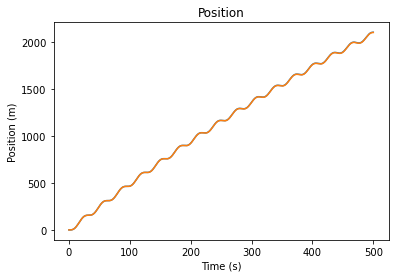

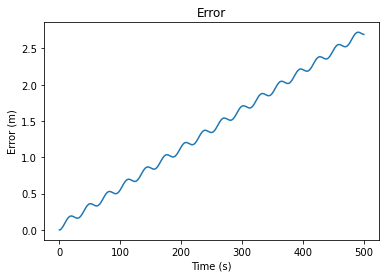

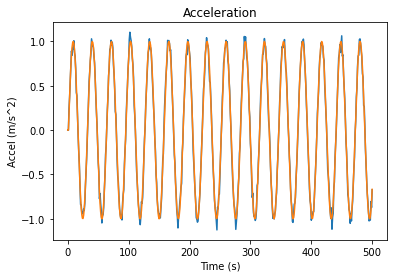

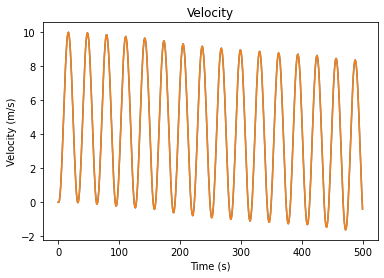

In [138]:
error = np.array(x) - np.array(actual_x)
Tf = np.linspace(0, T, T+1)

plt.figure(1)
plt.plot(Tf, x)
plt.plot(Tf, actual_x)
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.title("Position")

plt.figure(2)
plt.plot(Tf, error)
plt.xlabel("Time (s)")
plt.ylabel("Error (m)")
plt.title("Error")

plt.figure(3)
plt.plot(Tf, a)
plt.plot(Tf, actual_a)
plt.xlabel("Time (s)")
plt.ylabel("Accel (m/s^2)")
plt.title("Acceleration")

plt.figure(4)
plt.plot(Tf, v)
plt.plot(Tf, actual_v)
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("Velocity")

Text(0.5, 1.0, '2nd Diagonal Term in P')

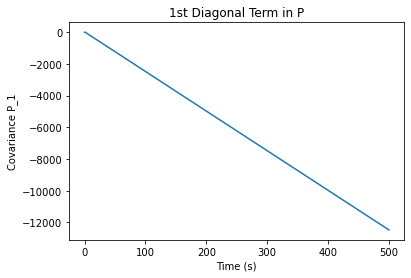

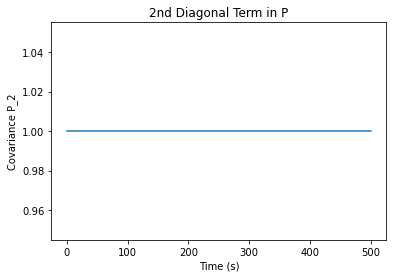

In [139]:
plt.figure(6)
plt.plot(Tf, P_1)
plt.xlabel("Time (s)")
plt.ylabel("Covariance P_1")
plt.title("1st Diagonal Term in P")

plt.figure(7)
plt.plot(Tf, P_2)
plt.xlabel("Time (s)")
plt.ylabel("Covariance P_2")
plt.title("2nd Diagonal Term in P")
